In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import pywt

### Load Dictionary .npy

In [24]:
dictionary = np.load('dictionary.npy', allow_pickle=True).item()
print(type(dictionary))
volunteers = sorted(dictionary.keys())
print('Volunteers:',volunteers)

<class 'dict'>
Volunteers: ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31']


### Signals access example

In [25]:
print(dictionary['S01'].keys())
print(dictionary['S01']['Lower'].keys())
print(dictionary['S01']['Lower']['Task1'].keys())
print(dictionary['S01']['Lower']['Task1']['X'].keys())

dict_keys(['Lower', 'Upper'])
dict_keys(['Task1', 'Task2', 'Task3'])
dict_keys(['X', 'Y'])
dict_keys(['Left', 'Rest', 'Right'])


In [26]:
df_info = pd.read_excel('C:/Users/Usuario/Documents/GitHub/Data_base_processing/Database_Info.xlsx')
upper_dominant = (df_info["Upper Dominant Laterality"]).tolist()
lower_dominant = (df_info["Lower Dominant Laterality"]).tolist()
print('Upper dominant=',upper_dominant)
print('Lower dominant=',lower_dominant)

Upper dominant= ['Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left']
Lower dominant= ['Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left']


# Wavelet - Feet

In [27]:
feet_channels = ['CZ', 'C4', 'C3', 'FZ', 'PZ']

trials, channels, samples = dictionary['S01']['Lower']['Task1']['X']['Rest'].shape
print(f"Trials={trials}|Channels={channels}|Samples={samples}")

volunteer = 1

if volunteer < 10:
    ini = 'S0'
else:
    ini = 'S'

X = dictionary[ini+str(volunteer)]['Lower']['Task1']['X']
Y = dictionary[ini+str(volunteer)]['Lower']['Task1']['Y']

Trials=80|Channels=5|Samples=1000


### Signal channel mean

In [28]:
def graph_mean_feet(trials, feet_channels,title):
    signals_class = { 'CZ': [], 'C4': [], 'C3': [], 'FZ': [], 'PZ': [] }
    
    # Construir signals_class
    for trial in range(len(trials)):
        signals_class['CZ'].append(trials[trial][0])
        signals_class['C4'].append(trials[trial][1])
        signals_class['C3'].append(trials[trial][2])
        signals_class['FZ'].append(trials[trial][3])
        signals_class['PZ'].append(trials[trial][4])

    # Crear la figura y los ejes
    fig, axes = plt.subplots(1, 5, figsize=(16, 4))

    # Graficar señales
    for idx, channel in enumerate(signals_class.keys()):
        mean = np.mean(signals_class[channel], axis=0)
        std = np.std(signals_class[channel], axis=0)
        
        axes[idx].plot(mean, label='Mean')
        axes[idx].fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5)
        axes[idx].set_title(feet_channels[idx])
        axes[idx].legend()
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()



(40, 5, 1000)


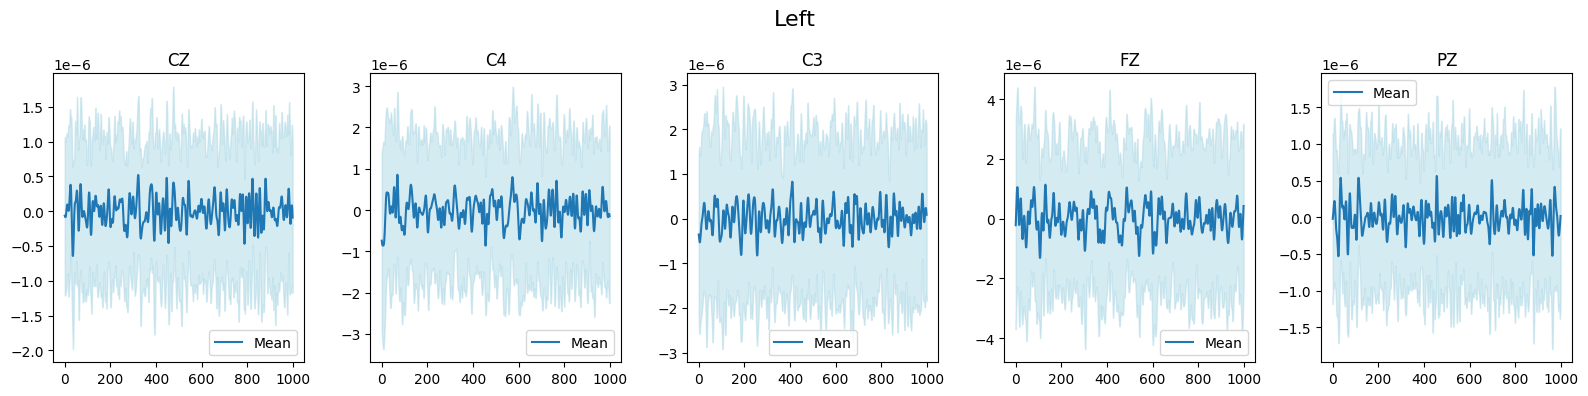

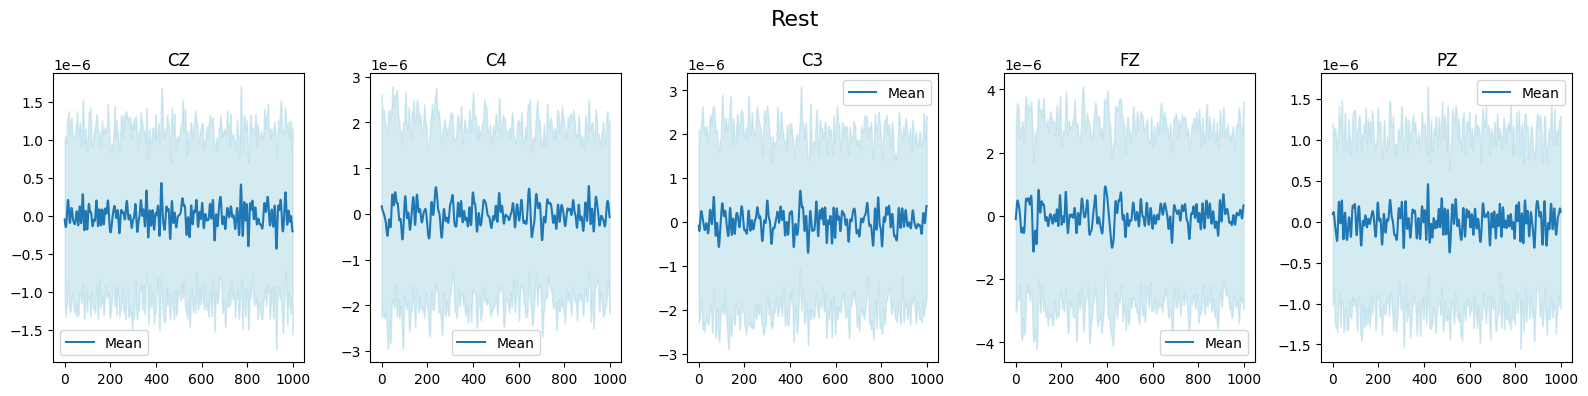

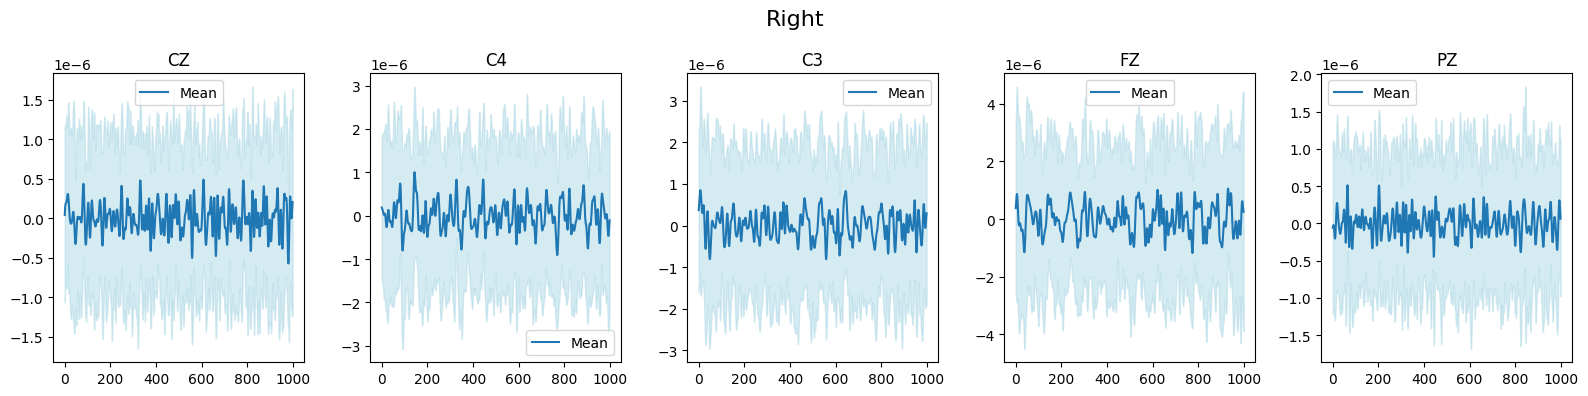

In [29]:
print((X['Left'].shape))
graph_mean_feet(X['Left'],feet_channels,'Left')
graph_mean_feet(X['Rest'],feet_channels,'Rest')
graph_mean_feet(X['Right'],feet_channels,'Right')
   

### Laplace filter

In [30]:
def laplacian_filter(senal):
  samples, channels, trials = senal.shape
  laplacian = np.empty((samples, trials), np.float64) 

  for i in range(trials):
      for k in range(samples):
          sample_sum = 0
          for j in range(channels - 1):
              sample_sum += senal[k, j, i] 
          laplacian[k, i] = senal[k, channels - 1, i] - (sample_sum / (channels - 1))  
  return laplacian

In [31]:
laplace_left = laplacian_filter(X['Left'])
trials, samples = laplace_left.shape
print(f"Left Trials={trials}|Samples={samples}")
laplace_right = laplacian_filter(X['Right'])
trials, samples = laplace_right.shape
print(f"Right Trials={trials}|Samples={samples}")
laplace_rest = laplacian_filter(X['Rest'])
trials, samples = laplace_rest.shape
print(f"Rest Trials={trials}|Samples={samples}")

Left Trials=40|Samples=1000
Right Trials=40|Samples=1000
Rest Trials=80|Samples=1000


In [32]:
# Graficar señales
def graph_signals(signals, title, x_axis=None):
    fig = plt.figure(figsize=(16, 4))
    mean = np.mean(signals, axis=0)
    std = np.std(signals, axis=0)

    if x_axis is None:
        x_axis = range(len(mean))  # Por defecto, usa 0 al número de muestras
    
    
    plt.plot(mean, label='Mean')
    plt.fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5)
    plt.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

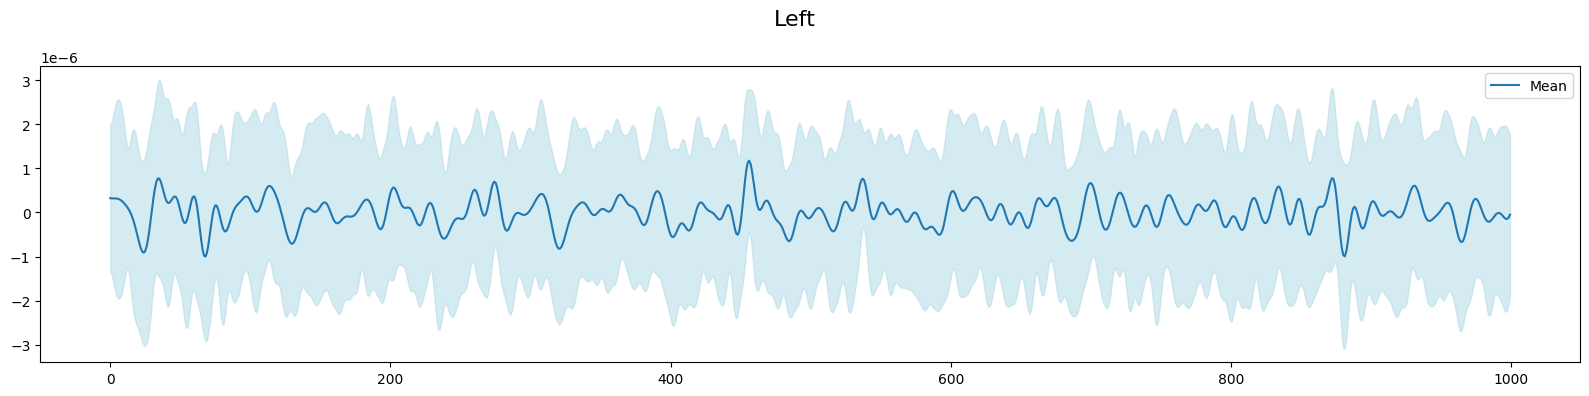

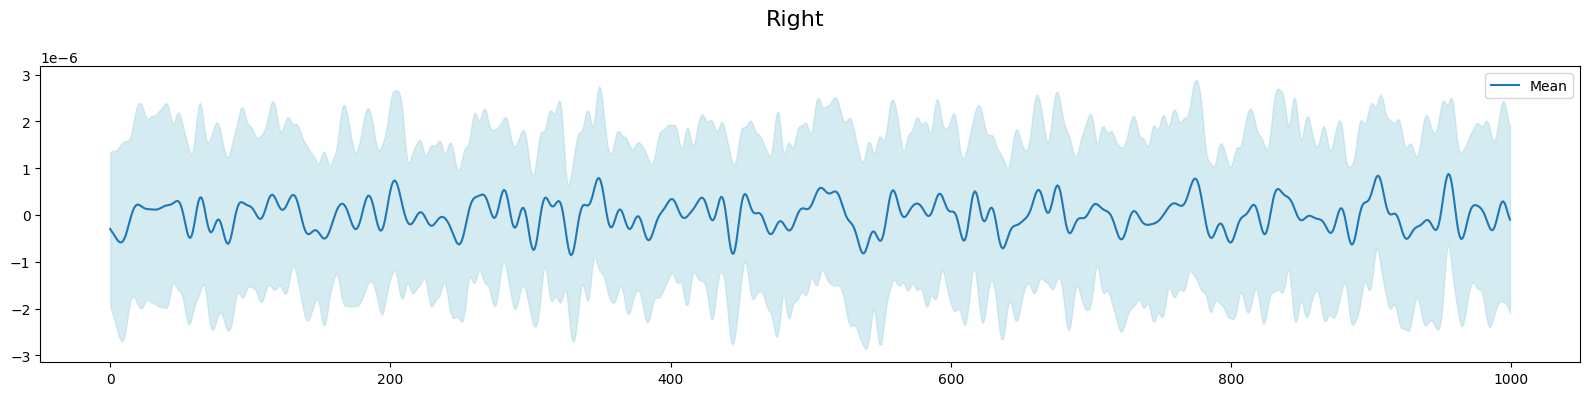

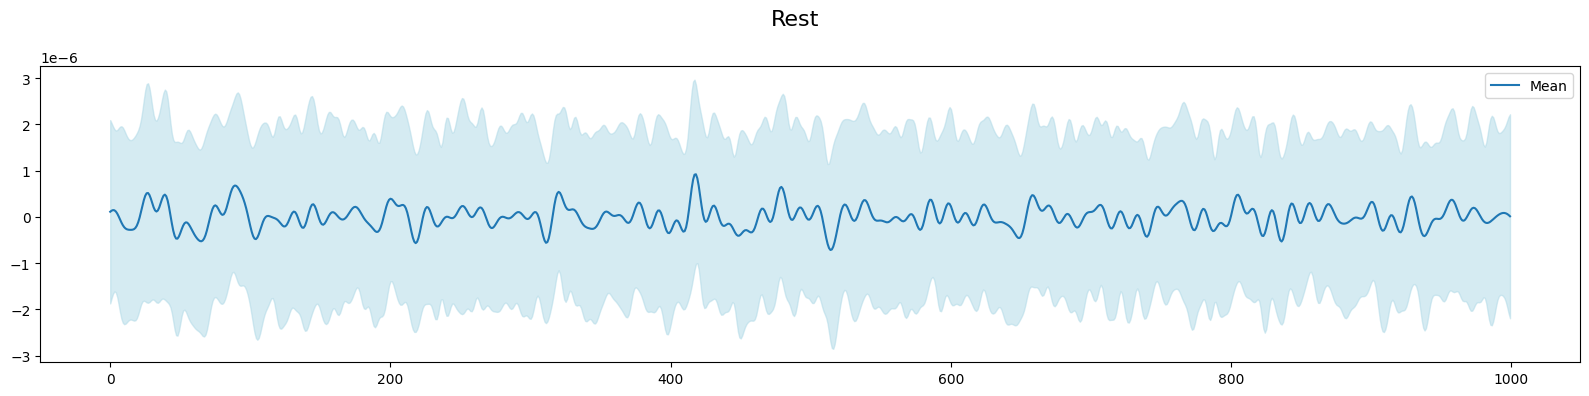

In [33]:
graph_signals(laplace_left,'Left')
graph_signals(laplace_right,'Right')
graph_signals(laplace_rest,'Rest')

### Wavelet

In [34]:
print(laplace_left.shape)

def Wavelet(signals, fs=500, nperseg=500, overlap=250):
    trials, samples = signals.shape
    wavelet_values = []
    for trial in range(trials):
        cA5,cD5,cD4,cD3,cD2,cD1 = pywt.wavedec(signals[trial],'bior6.8',mode='periodization',level=5)
        wavelet_values.append(np.concatenate((cD5,cD4)))
    
    wavelet_values = np.array(wavelet_values)
    return wavelet_values

(40, 1000)


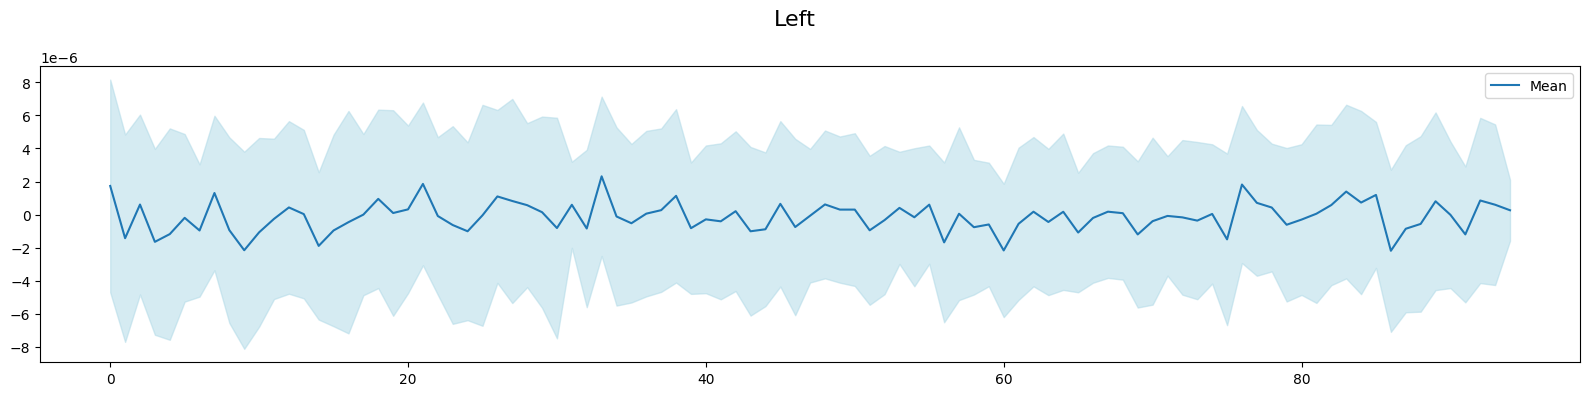

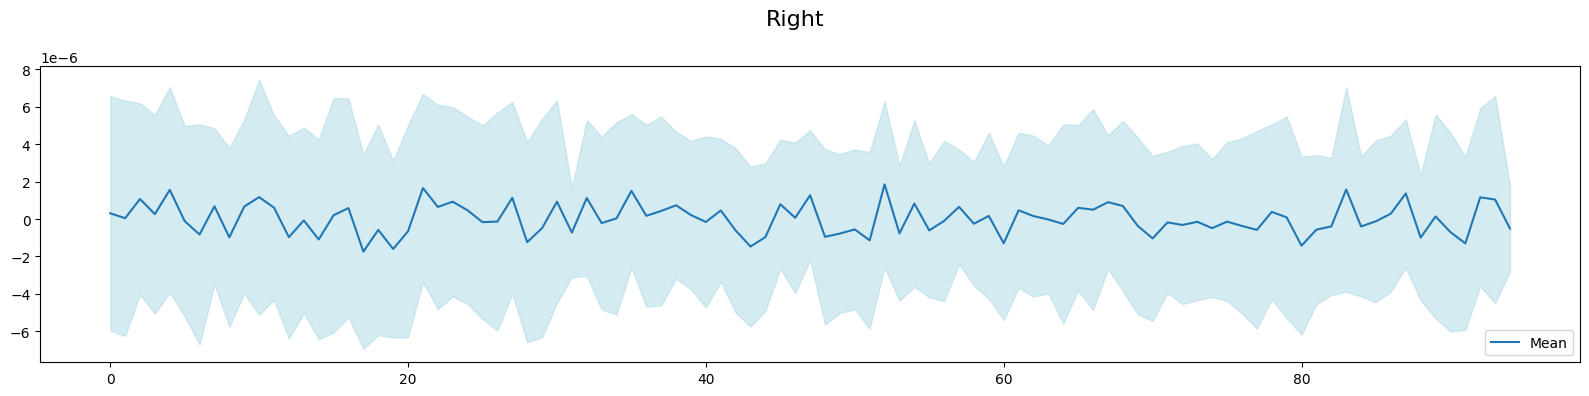

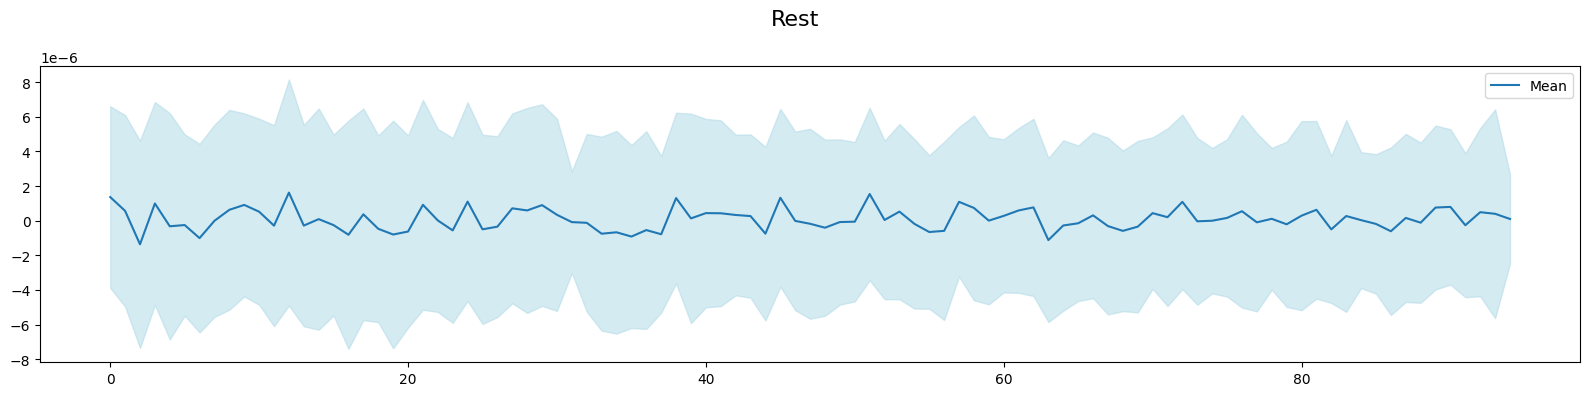

In [35]:
Wavelet_left = Wavelet(laplace_left)
Wavelet_right = Wavelet(laplace_right)
Wavelet_rest = Wavelet(laplace_rest)

graph_signals(Wavelet_left,'Left')
graph_signals(Wavelet_right,'Right')
graph_signals(Wavelet_rest,'Rest')


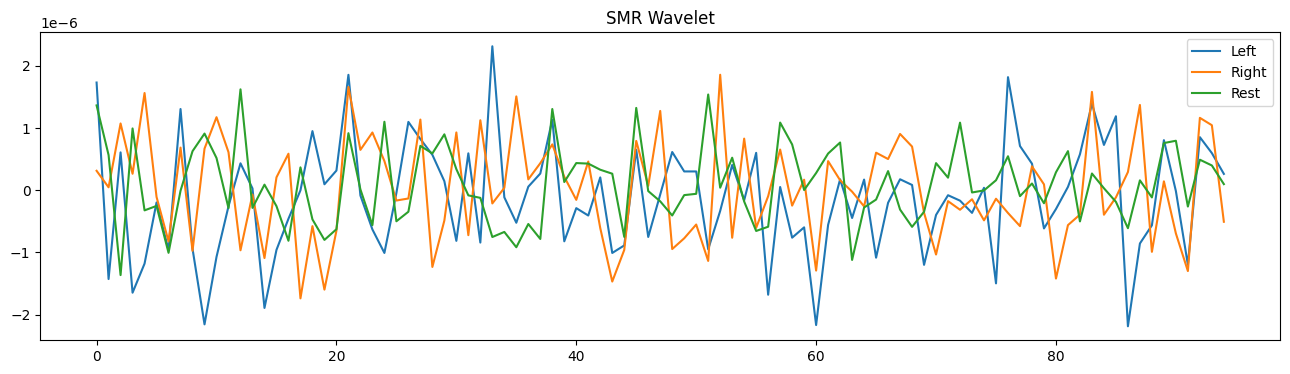

In [36]:
plt.figure(figsize=(16, 4))
plt.plot(np.mean(Wavelet_left, axis=0), label='Left')
plt.plot(np.mean(Wavelet_right, axis=0), label='Right')
plt.plot(np.mean(Wavelet_rest, axis=0), label='Rest')
plt.legend()
plt.title('SMR Wavelet')
plt.show()


### Clasificador

In [37]:
if lower_dominant[volunteer-1] == 'Right':
    index = np.random.choice(Wavelet_rest.shape[0], 40, replace=False) 
    selection = Wavelet_rest[index]
    X = np.concatenate((Wavelet_right, selection), axis=0)
else:
    index = np.random.choice(Wavelet_rest.shape[0], 40, replace=False) 
    selection = Wavelet_rest[index]
    X = np.concatenate((Wavelet_left, selection), axis=0)

y = np.concatenate((np.ones(40),np.zeros(40)), axis=0)

print('Tamaño X:', X.shape, 'Tamaño y:', y.shape)

Tamaño X: (80, 95) Tamaño y: (80,)


In [38]:
# Normalización
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

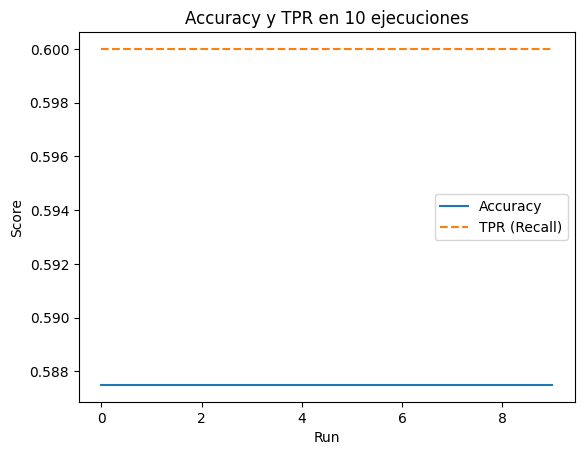

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


clf = LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

scoring = {'accuracy': 'accuracy', 'tpr': 'recall'}
acc = []
TPR = []
for run in range(10):
    acc_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    tpr_scores = cross_val_score(clf, X, y, cv=5, scoring='recall')

    acc.append(np.mean(acc_scores))
    TPR.append(np.mean(tpr_scores))

plt.figure()
plt.plot(acc, label='Accuracy')
plt.plot(TPR, label='TPR (Recall)', linestyle='dashed')
plt.legend()
plt.xlabel('Run')
plt.ylabel('Score')
plt.title('Accuracy y TPR en 10 ejecuciones')
plt.show()

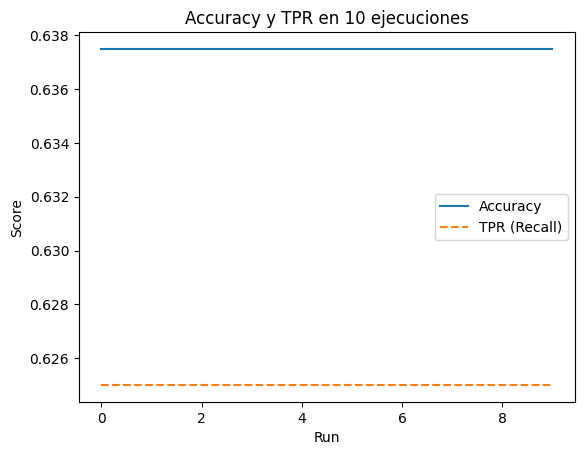

In [40]:
from sklearn.svm import SVC


clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

scoring = {'accuracy': 'accuracy', 'tpr': 'recall'}
acc = []
TPR = []
for run in range(10):
    acc_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    tpr_scores = cross_val_score(clf, X, y, cv=5, scoring='recall')

    acc.append(np.mean(acc_scores))
    TPR.append(np.mean(tpr_scores))

plt.figure()
plt.plot(acc, label='Accuracy')
plt.plot(TPR, label='TPR (Recall)', linestyle='dashed')
plt.legend()
plt.xlabel('Run')
plt.ylabel('Score')
plt.title('Accuracy y TPR en 10 ejecuciones')
plt.show()

[[6 2]
 [2 6]]
[[4 4]
 [1 7]]
[[4 4]
 [3 5]]
[[5 3]
 [6 2]]
[[4 4]
 [4 4]]


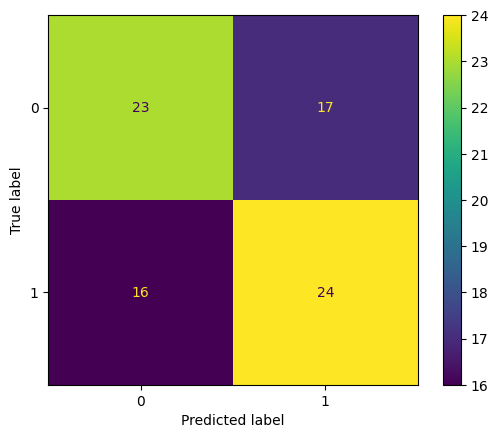

Accuracy promedio: 0.5875
Precision promedio: 0.5918
Recall promedio: 0.5875
F1-score promedio: 0.5808


In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lda = LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

accuracies = []
precisions = []
recalls = []
f1_scores = []
conf_matrices = []
num_clases = len(np.unique(y))  
sum_conf_matrix = np.zeros((num_clases, num_clases)) 

for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Train
    lda.fit(X_train, y_train)
    #Test
    y_pred = lda.predict(X_test)

    # Calcular métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Guardar métricas
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)
    print(conf_matrix)
    sum_conf_matrix += conf_matrix


# Calcular medias
mean_acc = np.mean(accuracies)
mean_prec = np.mean(precisions)
mean_rec = np.mean(recalls)
mean_f1 = np.mean(f1_scores)


# Results
cm_display = ConfusionMatrixDisplay(confusion_matrix = sum_conf_matrix)
cm_display.plot()
plt.show()

print(f'Accuracy promedio: {mean_acc:.4f}')
print(f'Precision promedio: {mean_prec:.4f}')
print(f'Recall promedio: {mean_rec:.4f}')
print(f'F1-score promedio: {mean_f1:.4f}')

    

### Validation

#### Tarea 2

In [42]:
X_T2 = dictionary[ini+str(volunteer)]['Lower']['Task2']['X']
Y_T2 = dictionary[ini+str(volunteer)]['Lower']['Task2']['Y']

(30, 5, 1000)


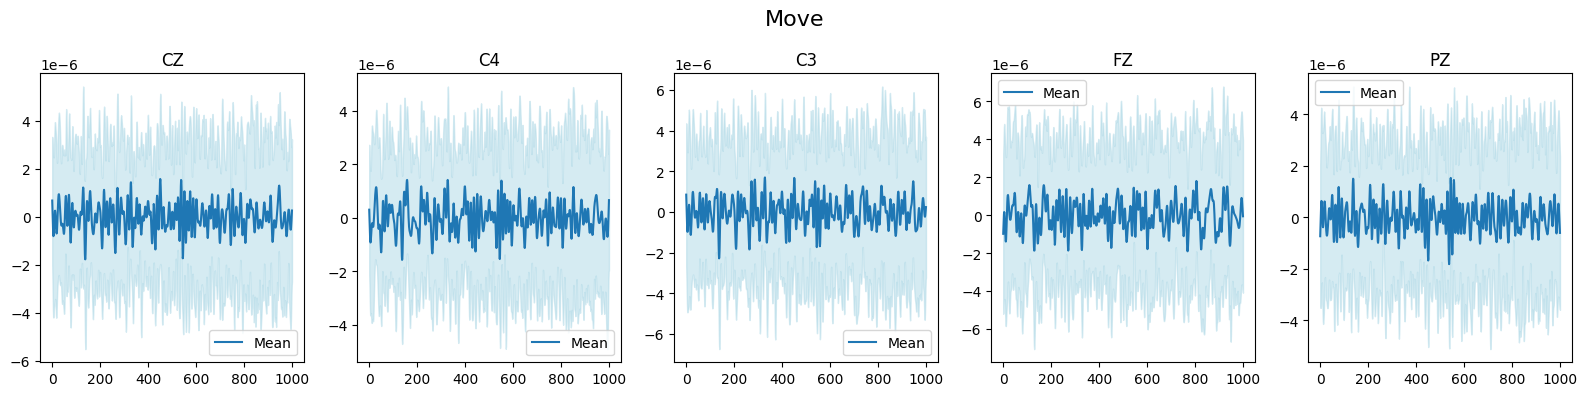

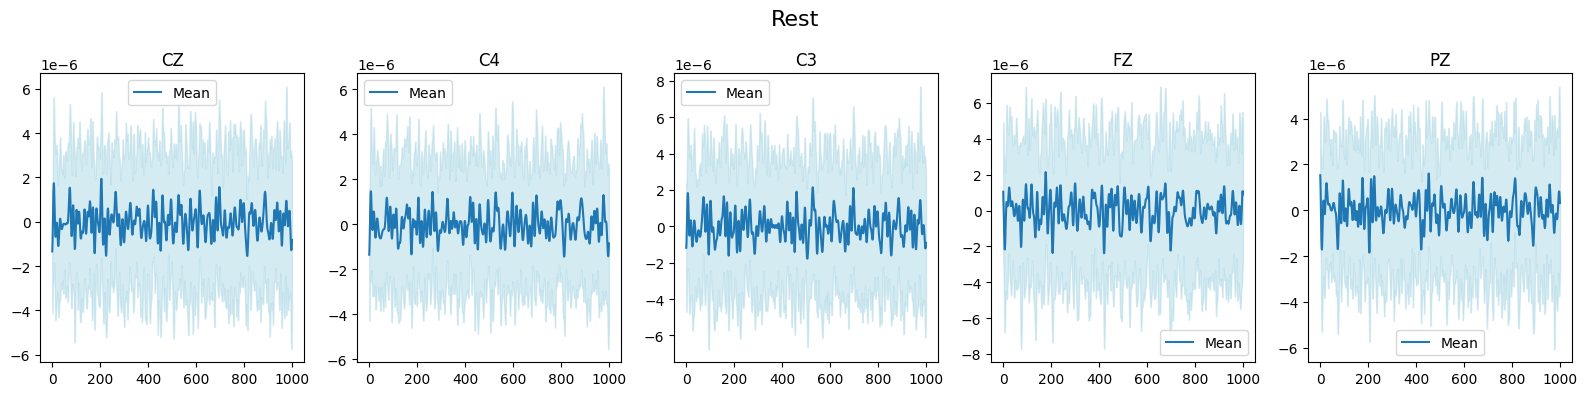

In [43]:
print((X_T2['Move'].shape))
graph_mean_feet(X_T2['Move'],feet_channels,'Move')
graph_mean_feet(X_T2['Rest'],feet_channels,'Rest')

In [44]:
laplace_move = laplacian_filter(X_T2['Move'])
trials, samples = laplace_move.shape
print(f"Move Trials={trials}|Samples={samples}")
laplace_rest = laplacian_filter(X_T2['Rest'])
trials, samples = laplace_rest.shape
print(f"Rest Trials={trials}|Samples={samples}")

Move Trials=30|Samples=1000
Rest Trials=30|Samples=1000


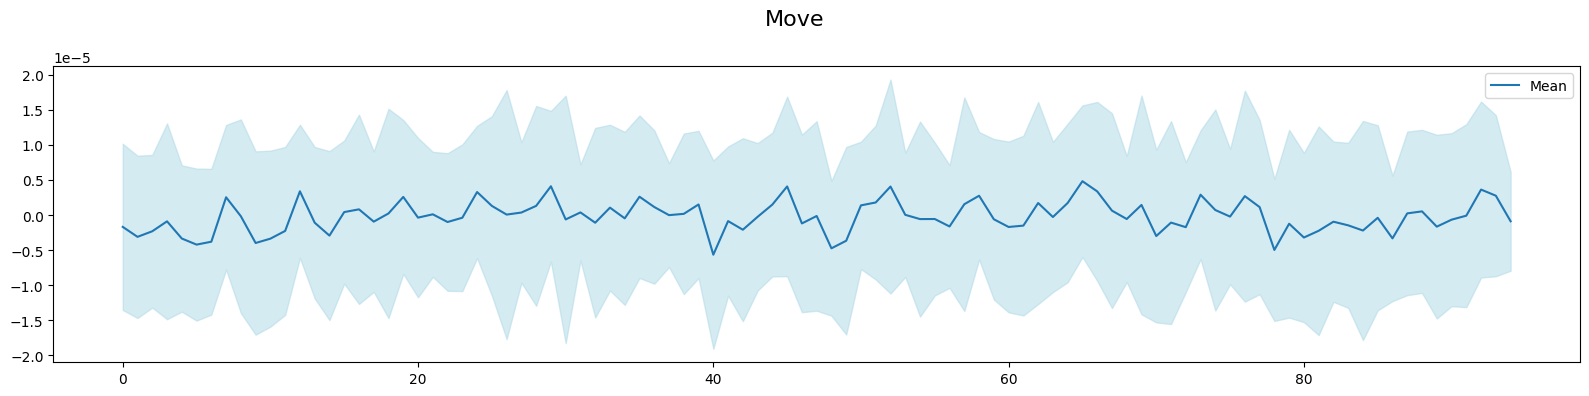

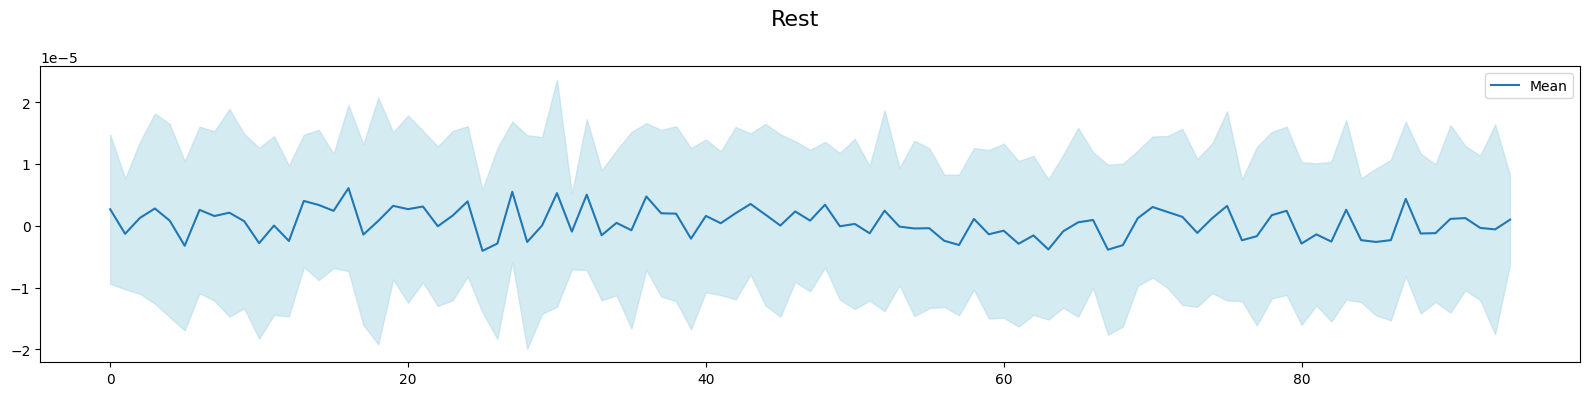

In [45]:
Wavelet_move = Wavelet(laplace_move)
Wavelet_rest = Wavelet(laplace_rest)

graph_signals(Wavelet_move,'Move')
graph_signals(Wavelet_rest,'Rest')

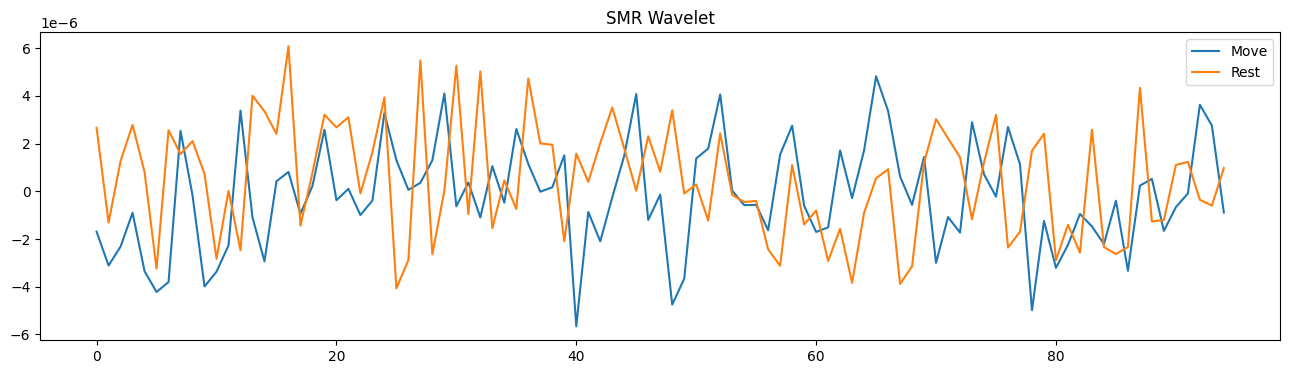

In [46]:
plt.figure(figsize=(16, 4))
plt.plot(np.mean(Wavelet_move, axis=0), label='Move')
plt.plot(np.mean(Wavelet_rest, axis=0), label='Rest')
plt.legend()
plt.title('SMR Wavelet')
plt.show()

Accuracy promedio: 0.5000
Precision promedio: 0.2500
Recall promedio: 0.5000
F1-score promedio: 0.3333


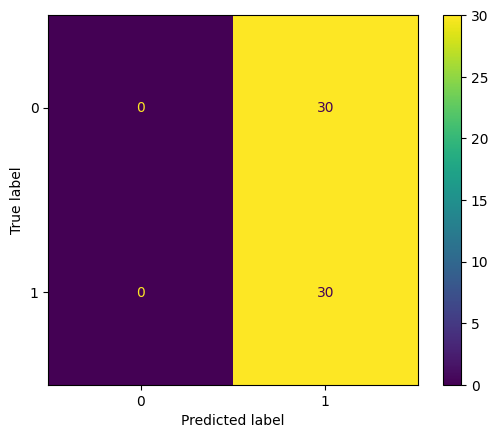

In [47]:
X_test = np.concatenate((Wavelet_move,Wavelet_rest), axis=0)
y_test = np.concatenate((np.ones(len(Wavelet_move)),(np.zeros(len(Wavelet_rest)))), axis=0)
y_pred = lda.predict(X_test)


# Calcular métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy promedio: {acc:.4f}')
print(f'Precision promedio: {prec:.4f}')
print(f'Recall promedio: {rec:.4f}')
print(f'F1-score promedio: {f1:.4f}')


cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
cm_display.plot()
plt.show()

#### Tarea 3

In [48]:
X_T3 = dictionary[ini+str(volunteer)]['Lower']['Task3']['X']
Y_T3 = dictionary[ini+str(volunteer)]['Lower']['Task3']['Y']

(30, 5, 1000)


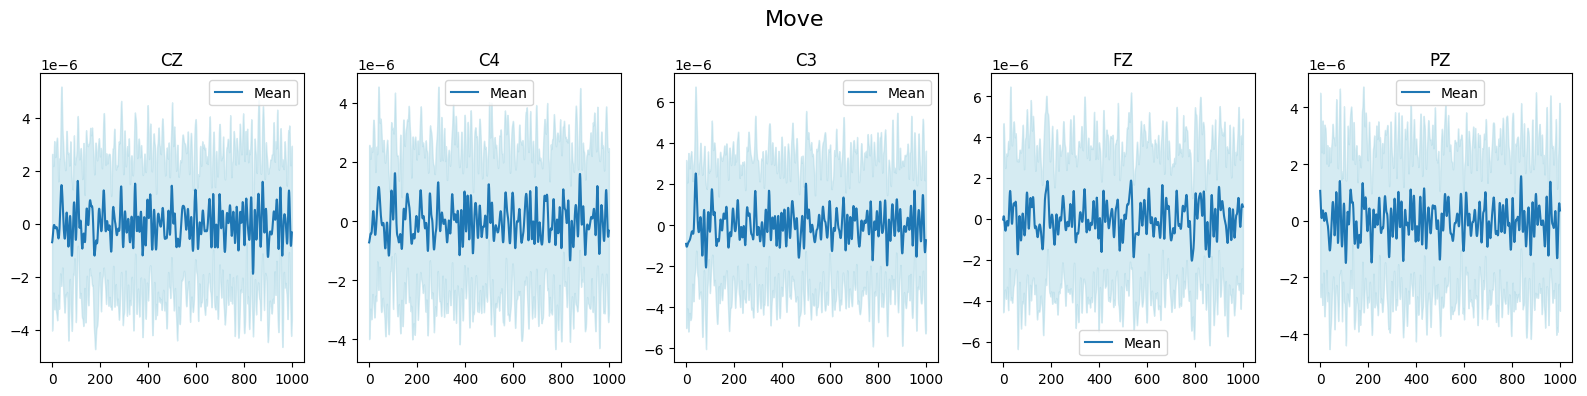

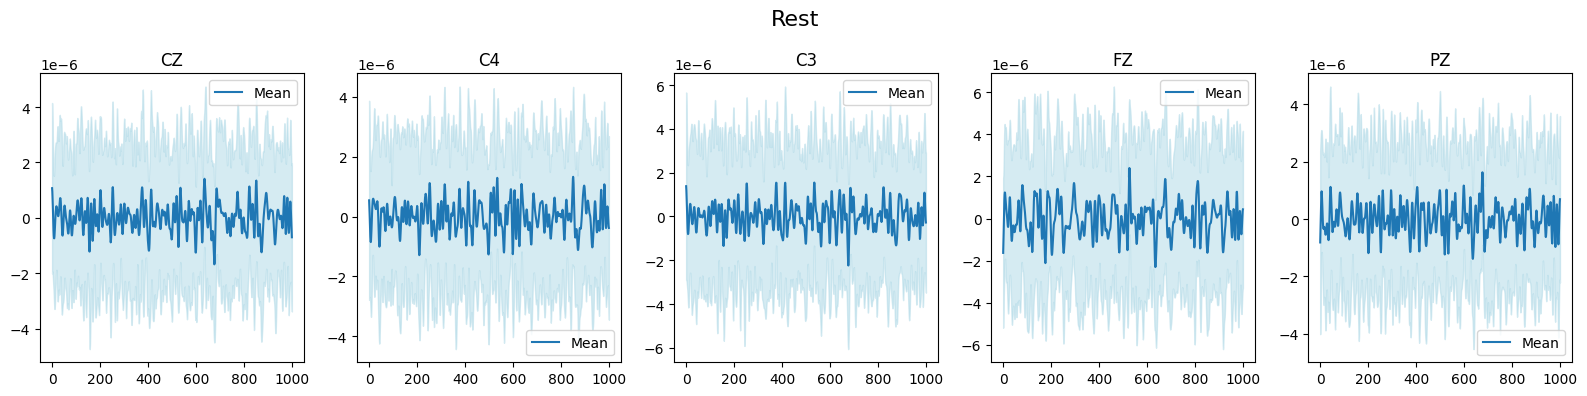

In [49]:
print((X_T3['Move'].shape))
graph_mean_feet(X_T3['Move'],feet_channels,'Move')
graph_mean_feet(X_T3['Rest'],feet_channels,'Rest')

In [50]:
laplace_move = laplacian_filter(X_T3['Move'])
trials, samples = laplace_move.shape
print(f"Move Trials={trials}|Samples={samples}")
laplace_rest = laplacian_filter(X_T3['Rest'])
trials, samples = laplace_rest.shape
print(f"Rest Trials={trials}|Samples={samples}")

Move Trials=30|Samples=1000
Rest Trials=30|Samples=1000


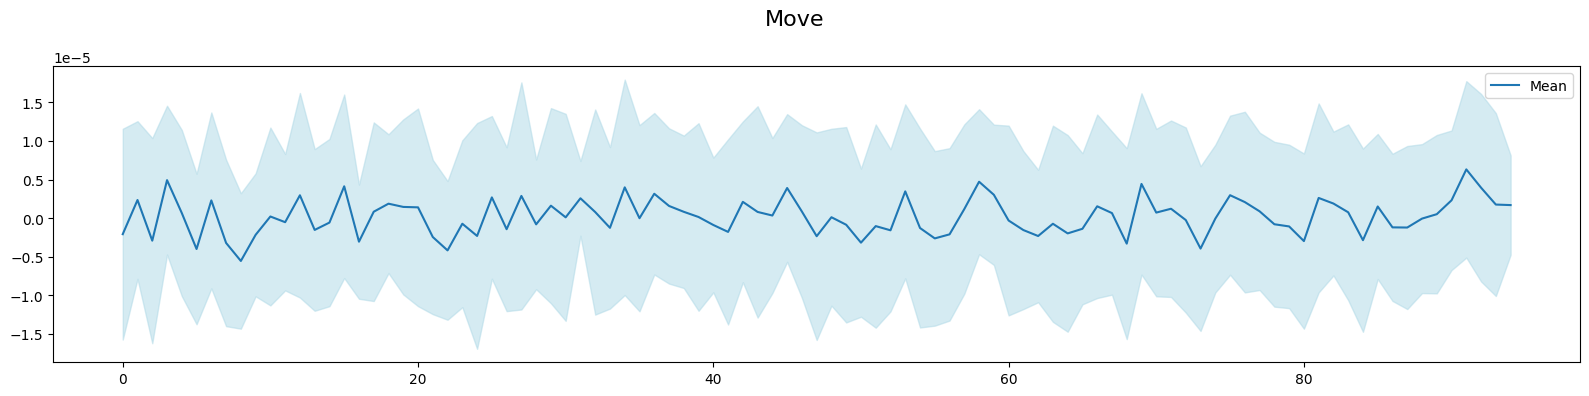

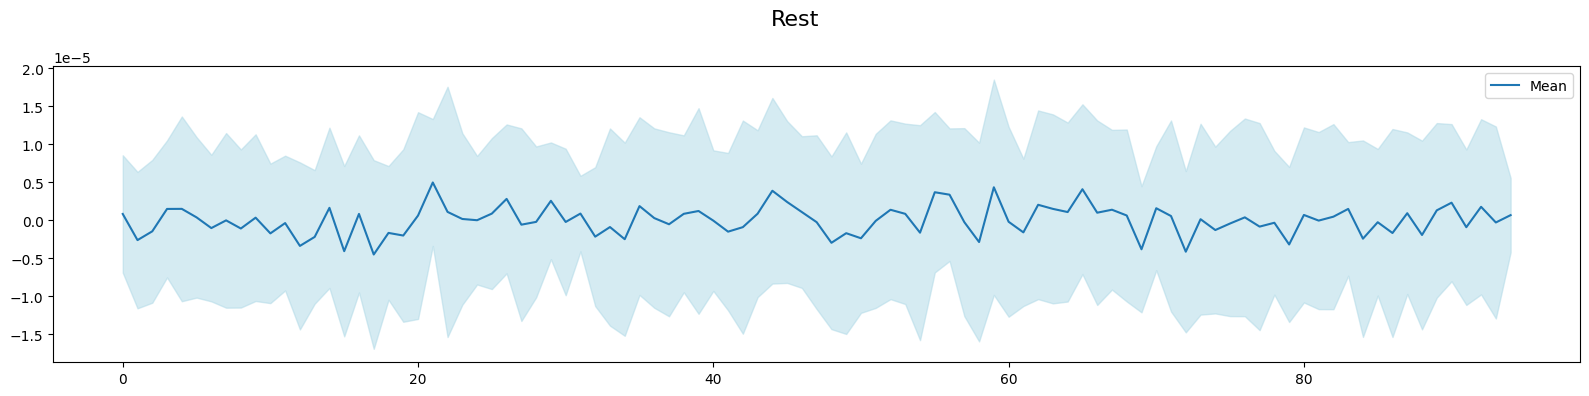

In [51]:
Wavelet_move = Wavelet(laplace_move)
Wavelet_rest = Wavelet(laplace_rest)

graph_signals(Wavelet_move,'Move')
graph_signals(Wavelet_rest,'Rest')

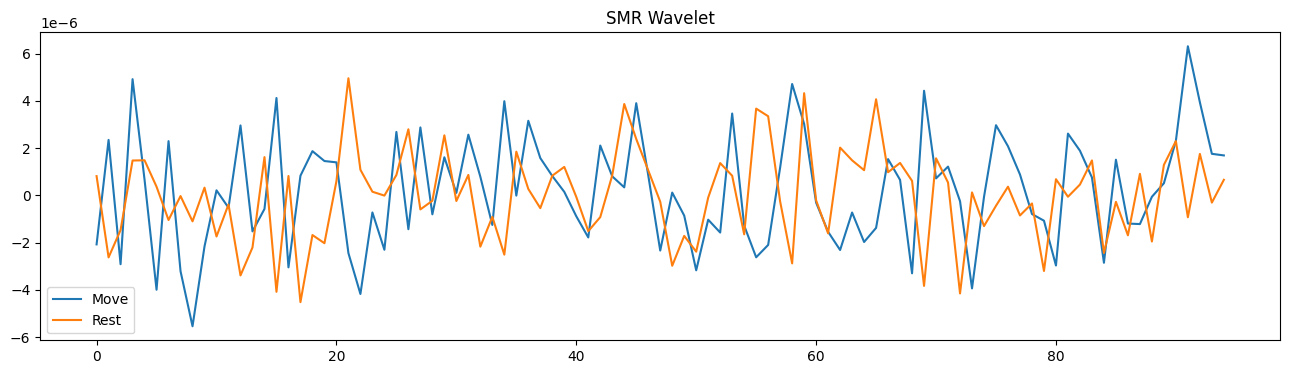

In [52]:
plt.figure(figsize=(16, 4))
plt.plot(np.mean(Wavelet_move, axis=0), label='Move')
plt.plot(np.mean(Wavelet_rest, axis=0), label='Rest')
plt.legend()
plt.title('SMR Wavelet')
plt.show()



Accuracy promedio: 0.5000
Precision promedio: 0.2500
Recall promedio: 0.5000
F1-score promedio: 0.3333


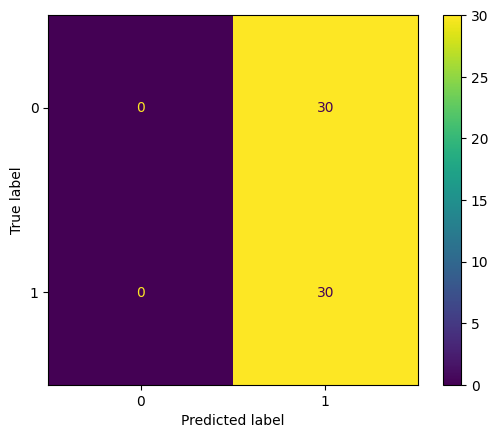

In [53]:
X_test = np.concatenate((Wavelet_move,Wavelet_rest), axis=0)
y_test = np.concatenate((np.ones(len(Wavelet_move)),(np.zeros(len(Wavelet_rest)))), axis=0)
y_pred = lda.predict(X_test)


# Calcular métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy promedio: {acc:.4f}')
print(f'Precision promedio: {prec:.4f}')
print(f'Recall promedio: {rec:.4f}')
print(f'F1-score promedio: {f1:.4f}')


cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
cm_display.plot()
plt.show()